![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/24.1.Improved_Entity_Resolution_with_SentenceChunkEmbeddings.ipynb)

# 24.1 Improved_Entity_Resolution_with_SentenceChunkEmbeddings

Enrich embeddings of chunks to get more accurate resolution results


In [2]:
import os

jsl_secret = os.getenv('SECRET')

import sparknlp
sparknlp_version = sparknlp.version()
import sparknlp_jsl
jsl_version = sparknlp_jsl.version()

print (jsl_secret)

In [3]:
import json
import os
import pandas as pd
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import SparkSession

from sparknlp.annotator import *
from sparknlp_jsl.annotator import *
from sparknlp.base import *
from sparknlp.util import *
import sparknlp_jsl
import sparknlp

from sparknlp.pretrained import ResourceDownloader
from pyspark.sql import functions as F

params = {"spark.driver.memory":"16G",
"spark.kryoserializer.buffer.max":"2000M",
"spark.driver.maxResultSize":"2000M"}

spark = sparknlp_jsl.start(jsl_secret,params=params)

print ("Spark NLP Version :", sparknlp.version())
print ("Spark NLP_JSL Version :", sparknlp_jsl.version())

Spark NLP Version : 3.2.1
Spark NLP_JSL Version : 3.2.0


<h1>!!! Warning !!!</h1>

**If you get an error related to Java port not found 55, it is probably because that the Colab memory cannot handle the model and the Spark session died. In that case, try on a larger machine or restart the kernel at the top and then come back here and rerun.**

## ICD10 CM Resolver Pipeline

In [4]:
documenter = DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("documents")
    
sentence_detector = SentenceDetector()\
    .setInputCols("documents")\
    .setOutputCol("sentences")
    
tokenizer = Tokenizer()\
    .setInputCols("sentences")\
    .setOutputCol("token")
    
embeddings = WordEmbeddingsModel()\
    .pretrained("embeddings_clinical", 'en', 'clinical/models')\
    .setInputCols(["sentences","token"])\
    .setOutputCol("embeddings")
    
ner = MedicalNerModel()\
    .pretrained("ner_jsl_greedy", "en", "clinical/models")\
    .setInputCols("sentences", "token","embeddings")\
    .setOutputCol("ner")
    
ner_converter = NerConverter()\
    .setInputCols("sentences", "token", "ner")\
    .setOutputCol("ner_chunk")

#Get average sentence-chunk Bert embeddings
sentence_chunk_embeddings = BertSentenceChunkEmbeddings\
    .pretrained("sbiobert_base_cased_mli", "en", "clinical/models")\
    .setInputCols(["sentences", "ner_chunk"])\
    .setOutputCol("sentence_chunk_embeddings").setChunkWeight(0.5) #default : 0.5



embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[OK!]
ner_jsl_greedy download started this may take some time.
Approximate size to download 14.5 MB
[OK!]
sbiobert_base_cased_mli download started this may take some time.
Approximate size to download 384.3 MB
[OK!]


In [11]:

def create_pipeline_model(resolver, whiteListed):

  ner_converter = NerConverter()\
    .setInputCols("sentences", "token", "ner")\
    .setOutputCol("ner_chunk")\
    .setWhiteList(whiteListed)

  pipeline = Pipeline().setStages(
  [
      documenter,
      sentence_detector, 
      tokenizer, 
      embeddings, 
      ner, 
      ner_converter, 
      sentence_chunk_embeddings,
      resolver
  ])
  
  return LightPipeline(pipeline.fit(spark.createDataFrame([['']]).toDF("text")))


In [6]:
icd_resolver = SentenceEntityResolverModel.pretrained('sbiobertresolve_icd10cm', 'en', 'clinical/models')\
            .setInputCols(["ner_chunk", "sentence_chunk_embeddings"]) \
            .setOutputCol("resolution")\
            .setDistanceFunction("EUCLIDEAN")

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

icd_model

sbiobertresolve_icd10cm download started this may take some time.
Approximate size to download 199 MB
[OK!]


In [7]:

cpt_resolver = SentenceEntityResolverModel.pretrained('sbiobertresolve_cpt_procedures_augmented', 'en', 'clinical/models')\
            .setInputCols(["ner_chunk", "sentence_chunk_embeddings"]) \
            .setOutputCol("resolution")\
            .setDistanceFunction("EUCLIDEAN")

cpt_whiteListed = ['Test'] #['External_body_part_or_region', 'Internal_organ_or_component', 'Direction','Test', 'Procedure']

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

sbiobertresolve_cpt_procedures_augmented download started this may take some time.
Approximate size to download 78.3 MB
[OK!]


**Helper function to process output**

In [12]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

def print_result(res):
    def get_res(col):
        dists = col.metadata['all_k_cosine_distances'].split(':::')[:5]
        resos = col.metadata['all_k_resolutions'].split(':::')[:5]
        reses = col.metadata['all_k_results'].split(':::')[:5]
        return pd.DataFrame({'code': reses, 'resolutions': resos , 'dist': dists})
    df_arr = []
    for chunk, resol in zip(res['ner_chunk'], res['resolution']):        
        t_df = get_res(resol)
        t_df['chunk'] = chunk.result
        t_df['entity'] = chunk.metadata['entity']
        
        df_arr.append(t_df)
        
    return pd.concat(df_arr, axis=0) 


## Examples

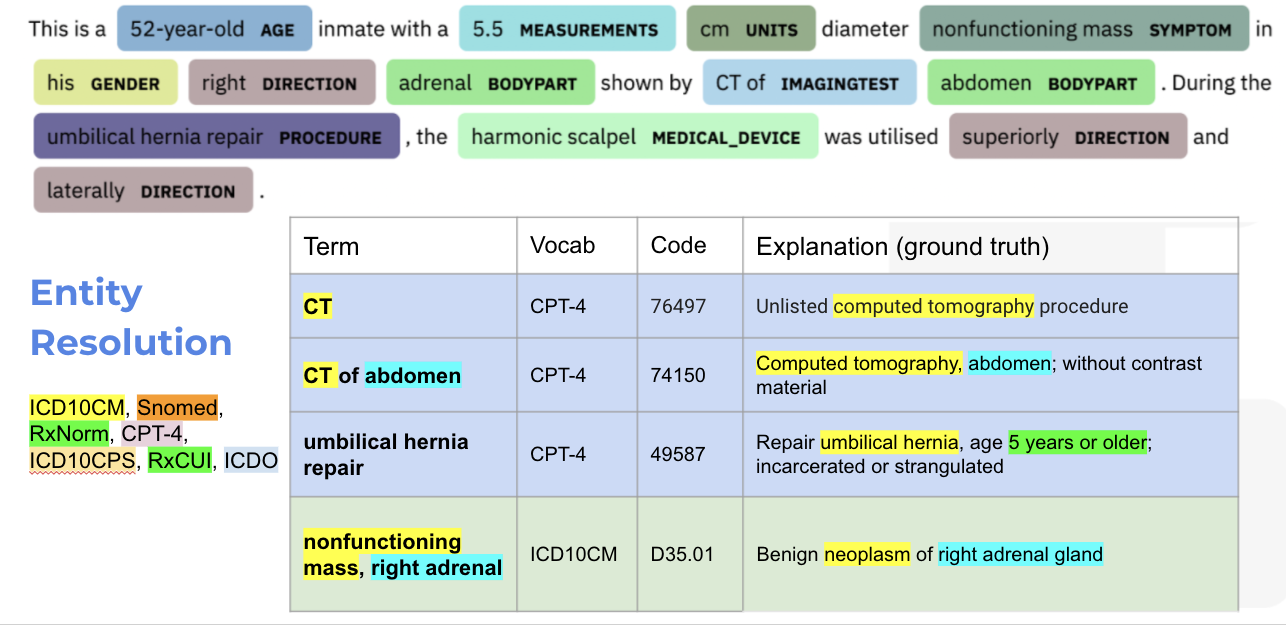

## CPT4

In [31]:
sentence_chunk_embeddings.setChunkWeight(0.5)

cpt_whiteListed = ['Test','Procedure'] 

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

text = "There is a benign tumor in his right adrenal shown by CT from his abdomen."

result = cpt_model.fullAnnotate(text)[0]

print_result(result)

code  ... entity
0  1010526  ...   Test
1    73200  ...   Test
2    73206  ...   Test
3    73202  ...   Test
4    76497  ...   Test

[5 rows x 5 columns]

In [32]:
sentence_chunk_embeddings.setChunkWeight(1.0)

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

text = "There is a benign tumor in his right adrenal shown by  CT from his abdomen."

result = cpt_model.fullAnnotate(text)[0]

print_result(result)

code  ... entity
0    76497  ...   Test
1    77073  ...   Test
2    91110  ...   Test
3  1015087  ...   Test
4  1010526  ...   Test

[5 rows x 5 columns]

### another example

In [16]:
sentence_chunk_embeddings.setChunkWeight(0.5)

cpt_whiteListed = ['Test','Procedure'] 

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

text = "extraction of cyst in kidney"

result = cpt_model.fullAnnotate(text)[0]

print_result(result)

code  ...     entity
0  50280  ...  Procedure
1  50290  ...  Procedure
2  50390  ...  Procedure
3  68020  ...  Procedure
4  62162  ...  Procedure

[5 rows x 5 columns]

In [17]:
sentence_chunk_embeddings.setChunkWeight(1)

cpt_whiteListed = ['Test','Procedure'] 

cpt_model = create_pipeline_model(cpt_resolver, cpt_whiteListed)

text = "extraction of cyst in kidney"

result = cpt_model.fullAnnotate(text)[0]

print_result(result)

code  ...     entity
0  68020  ...  Procedure
1  50290  ...  Procedure
2  25145  ...  Procedure
3  60200  ...  Procedure
4  39200  ...  Procedure

[5 rows x 5 columns]



## ICD-10

In [40]:
sentence_chunk_embeddings.setChunkWeight(1.0)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = "There is a benign tumor in his right adrenal shown by  CT from his abdomen."

result = icd_model.fullAnnotate(text)[0]

print_result(result)

code  ...       entity
0   D369  ...  Oncological
1   D159  ...  Oncological
2   D219  ...  Oncological
3  D3190  ...  Oncological
4   D141  ...  Oncological

[5 rows x 5 columns]

In [41]:
sentence_chunk_embeddings.setChunkWeight(0.5)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = "There is a benign tumor in his right adrenal shown by  CT from his abdomen."

result = icd_model.fullAnnotate(text)[0]

print_result(result)

code  ...       entity
0  D3500  ...  Oncological
1  D3191  ...  Oncological
2  D3A00  ...  Oncological
3  D3190  ...  Oncological
4  D3161  ...  Oncological

[5 rows x 5 columns]

#### another example

In [42]:
# Relying only on chunk - we get less specific results

sentence_chunk_embeddings.setChunkWeight(1.0)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = "She complains of pain in right leg."

result = icd_model.fullAnnotate(text)[0]

print_result(result)

code         resolutions    dist chunk   entity
0   R072     Precordial pain  0.0795  pain  Symptom
1  R6884            Jaw pain  0.0799  pain  Symptom
2  R1033  Periumbilical pain  0.0825  pain  Symptom
3   R141            Gas pain  0.0884  pain  Symptom
4  R0782    Intercostal pain  0.0919  pain  Symptom

In [43]:
# Using the entire sentence to get embedding

sentence_chunk_embeddings.setChunkWeight(0.5)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = "She complains of pain in right leg."

result = icd_model.fullAnnotate(text)[0]

print_result(result)

code                resolutions    dist chunk   entity
0  M79661    Pain in right lower leg  0.0698  pain  Symptom
1    R072            Precordial pain  0.0708  pain  Symptom
2   R1031  Right lower quadrant pain  0.0737  pain  Symptom
3   R1011  Right upper quadrant pain  0.0721  pain  Symptom
4   R1033         Periumbilical pain  0.0783  pain  Symptom

**Explanation:**

Even though the chunk itself does not specify right leg, we can still get that information from surrounding text

The "setChunkWeight" parameter has a default value of 0.5 - meaning taking equal representation of the cunk and sentence. Setting it to 1.0 would mean discarding the context information completely and only relying on the chunk, while a value of 0.0 would mean only relying on information in the sentence, not the chunk.

In [13]:
# a more elaborate example

sentence_chunk_embeddings.setChunkWeight(0.5)

icd_whiteListed = ['Symptom', 'Diabetes', 'Disease_Syndrome_Disorder','Oncological', 'Injury_or_Poisoning']

icd_model = create_pipeline_model(icd_resolver, icd_whiteListed)

text = """A 20 year old female patient badly tripped while going down stairs. She complains of right leg pain. 
Her x-ray showed right hip fracture. Hair line fractures also seen on the left knee joint.
She also suffered from trauma and slight injury on the head.

OTHER CONDITIONS: She was also recently diagnosed with diabetes, which is of type 2.
"""

result = icd_model.fullAnnotate(text)[0]

print_result(result)

code  ...               entity
0   M79661  ...              Symptom
1    R1031  ...              Symptom
2    R1012  ...              Symptom
3   I83811  ...              Symptom
4     G546  ...              Symptom
0  M84451S  ...  Injury_or_Poisoning
1  M84351S  ...  Injury_or_Poisoning
2  M84459P  ...  Injury_or_Poisoning
3  M84451A  ...  Injury_or_Poisoning
4  M84421S  ...  Injury_or_Poisoning
0  S92592P  ...  Injury_or_Poisoning
1  M84478P  ...  Injury_or_Poisoning
2  S82292P  ...  Injury_or_Poisoning
3  S92912P  ...  Injury_or_Poisoning
4  S42033S  ...  Injury_or_Poisoning
0  S0083XS  ...  Injury_or_Poisoning
1  S0083XD  ...  Injury_or_Poisoning
2  S078XXS  ...  Injury_or_Poisoning
3  S0093XS  ...  Injury_or_Poisoning
4  T148XXD  ...  Injury_or_Poisoning
0  S0080XD  ...  Injury_or_Poisoning
1  S0080XS  ...  Injury_or_Poisoning
2  S0080XA  ...  Injury_or_Poisoning
3  S0090XD  ...  Injury_or_Poisoning
4  S1080XS  ...  Injury_or_Poisoning
0    E1169  ...             Diabetes
1    E0969  ...             Diabetes
2     E118  ...             Diabetes
3     E098  ...             Diabetes
4    E1069  ...             Diabetes

[30 rows x 5 columns]

## RxNorm Resolver

In [8]:
rx_resolver = SentenceEntityResolverModel.pretrained('sbiobertresolve_rxnorm', 'en', 'clinical/models')\
            .setInputCols(["ner_chunk", "sentence_chunk_embeddings"]) \
            .setOutputCol("resolution")\
            .setDistanceFunction("EUCLIDEAN")


sbiobertresolve_rxnorm download started this may take some time.
Approximate size to download 802.6 MB
[OK!]


Even though the chunk only contains drug name, we can still more accurate code by looking at the form of drug

In [14]:
sentence_chunk_embeddings.setChunkWeight(0.5)

rx_whiteListed = ['Drug'] 

rxnorm_model = create_pipeline_model(rx_resolver, rx_whiteListed)

text = "rituximab in the form of injection"

result = rxnorm_model.fullAnnotate(text)[0]

print_result(result)

code                     resolutions    dist      chunk entity
0  1657861             rituximab injection  0.0268  rituximab   Drug
1   121191                       rituximab  0.0460  rituximab   Drug
2  1657863   rituximab injection [rituxan]  0.0543  rituximab   Drug
3  1157967    rituximab injectable product  0.0548  rituximab   Drug
4  2273515  rituximab injection [ruxience]  0.0593  rituximab   Drug

In [15]:
sentence_chunk_embeddings.setChunkWeight(1)

rx_whiteListed = ['Drug'] 

rxnorm_model = create_pipeline_model(rx_resolver, rx_whiteListed)

text = "rituximab in the form of injection"

result = rxnorm_model.fullAnnotate(text)[0]

print_result(result)

code          resolutions    dist      chunk entity
0   121191            rituximab  0.0000  rituximab   Drug
1  1657861  rituximab injection  0.0451  rituximab   Drug
2  2105824       rituximab-abbs  0.0549  rituximab   Drug
3   226754              rituxan  0.0556  rituximab   Drug
4   318341            cetuximab  0.0675  rituximab   Drug

## SNOMED Resolver

In [10]:
snomed_resolver = SentenceEntityResolverModel.pretrained("sbiobertresolve_snomed_findings","en", "clinical/models") \
      .setInputCols(["ner_chunk", "sentence_chunk_embeddings"]) \
      .setOutputCol("resolution")\
      .setDistanceFunction("EUCLIDEAN")

snomed_whiteListed = ['Drug', 'Symptom', 'Diabetes', 'Disease_Syndrome_Disorder', 'Oncological', 'Injury_or_Poisoning', 'Procedure', 'Treatment']

sbiobertresolve_snomed_findings download started this may take some time.
Approximate size to download 1.3 GB
[OK!]


In [ ]:
sentence_chunk_embeddings.setChunkWeight(0.5)

snomed_model = create_pipeline_model(snomed_resolver, snomed_whiteListed)

text = """A 20 year old female patient badly tripped while going down stairs. She complains of right leg pain. 
Her x-ray showed right hip fracture. Hair line fractures also seen on the left knee joint.
She also suffered from trauma and slight injury on the head.

OTHER CONDITIONS: She was also recently diagnosed with diabetes, which is of type 2.

She we through 
"""

result = snomed_model.fullAnnotate(text)[0]

print_result(result)

code  ...               entity
0          203124006  ...              Symptom
1    316941000119108  ...              Symptom
2  12247531000119106  ...              Symptom
3          203127004  ...              Symptom
4      5771000119106  ...              Symptom
0          208520007  ...  Injury_or_Poisoning
1          263225007  ...  Injury_or_Poisoning
2  11315041000119101  ...  Injury_or_Poisoning
3          704063001  ...  Injury_or_Poisoning
4            5913000  ...  Injury_or_Poisoning
0          213547009  ...  Injury_or_Poisoning
1          403344005  ...  Injury_or_Poisoning
2  11306001000119107  ...  Injury_or_Poisoning
3          771493007  ...  Injury_or_Poisoning
4            4478002  ...  Injury_or_Poisoning
0          419945001  ...  Injury_or_Poisoning
1          417746004  ...  Injury_or_Poisoning
2          781645001  ...  Injury_or_Poisoning
3           57029005  ...  Injury_or_Poisoning
4           82271004  ...  Injury_or_Poisoning
0          210043001  ...  Injury_or_Poisoning
1          157327004  ...  Injury_or_Poisoning
2          274164006  ...  Injury_or_Poisoning
3          210018007  ...  Injury_or_Poisoning
4          283025007  ...  Injury_or_Poisoning
0            8801005  ...             Diabetes
1            5368009  ...             Diabetes
2          408544007  ...             Diabetes
3          199230006  ...             Diabetes
4           82980005  ...             Diabetes

[30 rows x 5 columns]